# Convolutional Neural Network  - Transfer Learning

Dataset in use: https://www.kaggle.com/datasets/cashutosh/gender-classification-dataset/data

In [1]:
import torch
import torchvision
import numpy as np
import torch.nn as nn
from PIL import Image
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, random_split
from torch.optim.lr_scheduler import StepLR
from torchvision import datasets, models, transforms
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

In [2]:
train_dir = "./dataset/Training"
test_dir = "./dataset/Validation"
input_size = (224, 224)
batch_size = 64

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [4]:
transform = {
    'train': transforms.Compose([
        transforms.Resize(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [15]:
full_dataset = datasets.ImageFolder(root=train_dir, transform=transform['train'])
test_dataset = datasets.ImageFolder(root=test_dir, transform=transform['test'])

train_size = int(0.9 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

image_datasets = {
    'train': train_dataset,
    'val': val_dataset,
    'test': test_dataset
}

dataloaders = {
    'train': DataLoader(image_datasets['train'], batch_size=batch_size, shuffle=True),
    'val': DataLoader(image_datasets['val'], batch_size=batch_size, shuffle=False),  # Changed from 'test' to 'val'
    'test': DataLoader(image_datasets['test'], batch_size=batch_size, shuffle=False)  # Changed from 'test' to 'val'
}

In [6]:
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = full_dataset.classes

In [7]:
# Load Model
model = models.vgg19(pretrained=True)

# Freeze Layers
for param in model.parameters():
    param.requires_grad = False

# Custom Classifier
num_features = model.classifier[6].in_features
model.classifier[6] = nn.Sequential(
    nn.Linear(num_features, 256),
    nn.ReLU(),
    nn.Dropout(0.1), # Dropout is applied with probability 0.1 to prevent overfitting
    nn.Linear(256, 2)  # Output is 2 dimensional (male and female)
)

model = model.to(device)

# Loss function
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.013) # Adam Optimizer

scheduler = StepLR(optimizer, step_size=2, gamma=0.1)

C:\Users\aerol\env\facenv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\aerol\env\facenv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


## Training

In [8]:
# After feedback, VGG19 is trained (in presentation, we presented VGG16 model.) with early stop and dynamic learning rate.
# Test and Validation sets are seperated btw each other

In [9]:
all_preds = []
all_labels = []

In [10]:
best_val_loss = np.inf
patience = 3
counter = 0

In [11]:
num_epochs = 10
for epoch in range(num_epochs):
    
    if counter >= patience:
        print(f"Early stopping in iteration {counter} -->> no improvement in validation loss.")
        break
    
    for phase in ['train', 'val']:
        if phase == 'train':
            model.train()
        else:
            model.eval()

        running_loss = 0.0
        running_corrects = 0
        total_batches = len(dataloaders[phase])

        for batch_idx, (inputs, labels) in enumerate(dataloaders[phase]):
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            with torch.set_grad_enabled(phase == 'train'):
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                if phase == 'train':
                    loss.backward()
                    optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
            
            #all_preds.extend(preds.cpu().numpy())
            #all_labels.extend(labels.cpu().numpy())
            
            batch_loss = loss.item()
            print(f'Epoch [{epoch+1}/{num_epochs}], Phase: {phase}, Batch: [{batch_idx+1}/{total_batches}], Loss: {batch_loss:.4f}')

        epoch_loss = running_loss / dataset_sizes[phase]
        epoch_acc = running_corrects.double() / dataset_sizes[phase]
        scheduler.step()

        print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
        
        if phase == 'val' and epoch_loss < best_val_loss:
            best_val_loss = epoch_loss
            counter = 0
        elif phase == 'val':
            counter += 1

Epoch [1/10], Phase: train, Batch: [1/657], Loss: 0.7188
Epoch [1/10], Phase: train, Batch: [2/657], Loss: 11.8351
Epoch [1/10], Phase: train, Batch: [3/657], Loss: 0.2369
Epoch [1/10], Phase: train, Batch: [4/657], Loss: 2.5872
Epoch [1/10], Phase: train, Batch: [5/657], Loss: 0.6715
Epoch [1/10], Phase: train, Batch: [6/657], Loss: 0.5410
Epoch [1/10], Phase: train, Batch: [7/657], Loss: 0.5529
Epoch [1/10], Phase: train, Batch: [8/657], Loss: 0.5659
Epoch [1/10], Phase: train, Batch: [9/657], Loss: 0.4767
Epoch [1/10], Phase: train, Batch: [10/657], Loss: 0.2657
Epoch [1/10], Phase: train, Batch: [11/657], Loss: 0.3333
Epoch [1/10], Phase: train, Batch: [12/657], Loss: 0.4823
Epoch [1/10], Phase: train, Batch: [13/657], Loss: 0.3700
Epoch [1/10], Phase: train, Batch: [14/657], Loss: 0.3673
Epoch [1/10], Phase: train, Batch: [15/657], Loss: 0.2280
Epoch [1/10], Phase: train, Batch: [16/657], Loss: 0.6266
Epoch [1/10], Phase: train, Batch: [17/657], Loss: 0.3070
Epoch [1/10], Phase: t

Epoch [1/10], Phase: train, Batch: [142/657], Loss: 0.2970
Epoch [1/10], Phase: train, Batch: [143/657], Loss: 0.5632
Epoch [1/10], Phase: train, Batch: [144/657], Loss: 0.3126
Epoch [1/10], Phase: train, Batch: [145/657], Loss: 0.1743
Epoch [1/10], Phase: train, Batch: [146/657], Loss: 0.1991
Epoch [1/10], Phase: train, Batch: [147/657], Loss: 0.3512
Epoch [1/10], Phase: train, Batch: [148/657], Loss: 0.2742
Epoch [1/10], Phase: train, Batch: [149/657], Loss: 0.3001
Epoch [1/10], Phase: train, Batch: [150/657], Loss: 0.2897
Epoch [1/10], Phase: train, Batch: [151/657], Loss: 0.3128
Epoch [1/10], Phase: train, Batch: [152/657], Loss: 0.2449
Epoch [1/10], Phase: train, Batch: [153/657], Loss: 0.3205
Epoch [1/10], Phase: train, Batch: [154/657], Loss: 0.3634
Epoch [1/10], Phase: train, Batch: [155/657], Loss: 0.2695
Epoch [1/10], Phase: train, Batch: [156/657], Loss: 0.2413
Epoch [1/10], Phase: train, Batch: [157/657], Loss: 0.4568
Epoch [1/10], Phase: train, Batch: [158/657], Loss: 0.20

Epoch [1/10], Phase: train, Batch: [281/657], Loss: 0.3005
Epoch [1/10], Phase: train, Batch: [282/657], Loss: 0.5584
Epoch [1/10], Phase: train, Batch: [283/657], Loss: 0.2537
Epoch [1/10], Phase: train, Batch: [284/657], Loss: 0.3785
Epoch [1/10], Phase: train, Batch: [285/657], Loss: 0.3921
Epoch [1/10], Phase: train, Batch: [286/657], Loss: 0.1806
Epoch [1/10], Phase: train, Batch: [287/657], Loss: 0.3239
Epoch [1/10], Phase: train, Batch: [288/657], Loss: 0.2762
Epoch [1/10], Phase: train, Batch: [289/657], Loss: 0.2378
Epoch [1/10], Phase: train, Batch: [290/657], Loss: 0.1548
Epoch [1/10], Phase: train, Batch: [291/657], Loss: 0.2806
Epoch [1/10], Phase: train, Batch: [292/657], Loss: 0.2439
Epoch [1/10], Phase: train, Batch: [293/657], Loss: 0.2512
Epoch [1/10], Phase: train, Batch: [294/657], Loss: 0.3482
Epoch [1/10], Phase: train, Batch: [295/657], Loss: 0.1688
Epoch [1/10], Phase: train, Batch: [296/657], Loss: 0.2378
Epoch [1/10], Phase: train, Batch: [297/657], Loss: 0.31

Epoch [1/10], Phase: train, Batch: [420/657], Loss: 0.2001
Epoch [1/10], Phase: train, Batch: [421/657], Loss: 0.2500
Epoch [1/10], Phase: train, Batch: [422/657], Loss: 0.3050
Epoch [1/10], Phase: train, Batch: [423/657], Loss: 0.2792
Epoch [1/10], Phase: train, Batch: [424/657], Loss: 0.2455
Epoch [1/10], Phase: train, Batch: [425/657], Loss: 0.3103
Epoch [1/10], Phase: train, Batch: [426/657], Loss: 0.2086
Epoch [1/10], Phase: train, Batch: [427/657], Loss: 0.2804
Epoch [1/10], Phase: train, Batch: [428/657], Loss: 0.3735
Epoch [1/10], Phase: train, Batch: [429/657], Loss: 0.3848
Epoch [1/10], Phase: train, Batch: [430/657], Loss: 0.3376
Epoch [1/10], Phase: train, Batch: [431/657], Loss: 0.6003
Epoch [1/10], Phase: train, Batch: [432/657], Loss: 0.3474
Epoch [1/10], Phase: train, Batch: [433/657], Loss: 0.1857
Epoch [1/10], Phase: train, Batch: [434/657], Loss: 0.3602
Epoch [1/10], Phase: train, Batch: [435/657], Loss: 0.2333
Epoch [1/10], Phase: train, Batch: [436/657], Loss: 0.37

Epoch [1/10], Phase: train, Batch: [559/657], Loss: 0.3676
Epoch [1/10], Phase: train, Batch: [560/657], Loss: 0.2369
Epoch [1/10], Phase: train, Batch: [561/657], Loss: 0.3390
Epoch [1/10], Phase: train, Batch: [562/657], Loss: 0.1897
Epoch [1/10], Phase: train, Batch: [563/657], Loss: 0.2054
Epoch [1/10], Phase: train, Batch: [564/657], Loss: 0.2933
Epoch [1/10], Phase: train, Batch: [565/657], Loss: 0.1927
Epoch [1/10], Phase: train, Batch: [566/657], Loss: 0.2642
Epoch [1/10], Phase: train, Batch: [567/657], Loss: 0.5512
Epoch [1/10], Phase: train, Batch: [568/657], Loss: 0.3087
Epoch [1/10], Phase: train, Batch: [569/657], Loss: 0.1165
Epoch [1/10], Phase: train, Batch: [570/657], Loss: 0.2775
Epoch [1/10], Phase: train, Batch: [571/657], Loss: 0.4763
Epoch [1/10], Phase: train, Batch: [572/657], Loss: 0.2704
Epoch [1/10], Phase: train, Batch: [573/657], Loss: 0.1539
Epoch [1/10], Phase: train, Batch: [574/657], Loss: 0.2016
Epoch [1/10], Phase: train, Batch: [575/657], Loss: 0.25

Epoch [1/10], Phase: val, Batch: [44/73], Loss: 0.2424
Epoch [1/10], Phase: val, Batch: [45/73], Loss: 0.2189
Epoch [1/10], Phase: val, Batch: [46/73], Loss: 0.3165
Epoch [1/10], Phase: val, Batch: [47/73], Loss: 0.2920
Epoch [1/10], Phase: val, Batch: [48/73], Loss: 0.1598
Epoch [1/10], Phase: val, Batch: [49/73], Loss: 0.2938
Epoch [1/10], Phase: val, Batch: [50/73], Loss: 0.1753
Epoch [1/10], Phase: val, Batch: [51/73], Loss: 0.3430
Epoch [1/10], Phase: val, Batch: [52/73], Loss: 0.2121
Epoch [1/10], Phase: val, Batch: [53/73], Loss: 0.2600
Epoch [1/10], Phase: val, Batch: [54/73], Loss: 0.2196
Epoch [1/10], Phase: val, Batch: [55/73], Loss: 0.2620
Epoch [1/10], Phase: val, Batch: [56/73], Loss: 0.3254
Epoch [1/10], Phase: val, Batch: [57/73], Loss: 0.1494
Epoch [1/10], Phase: val, Batch: [58/73], Loss: 0.2426
Epoch [1/10], Phase: val, Batch: [59/73], Loss: 0.2246
Epoch [1/10], Phase: val, Batch: [60/73], Loss: 0.1901
Epoch [1/10], Phase: val, Batch: [61/73], Loss: 0.3430
Epoch [1/1

Epoch [2/10], Phase: train, Batch: [114/657], Loss: 0.2264
Epoch [2/10], Phase: train, Batch: [115/657], Loss: 0.3010
Epoch [2/10], Phase: train, Batch: [116/657], Loss: 0.3853
Epoch [2/10], Phase: train, Batch: [117/657], Loss: 0.3146
Epoch [2/10], Phase: train, Batch: [118/657], Loss: 0.4230
Epoch [2/10], Phase: train, Batch: [119/657], Loss: 0.6534
Epoch [2/10], Phase: train, Batch: [120/657], Loss: 0.5097
Epoch [2/10], Phase: train, Batch: [121/657], Loss: 0.3798
Epoch [2/10], Phase: train, Batch: [122/657], Loss: 0.2270
Epoch [2/10], Phase: train, Batch: [123/657], Loss: 0.1865
Epoch [2/10], Phase: train, Batch: [124/657], Loss: 0.2835
Epoch [2/10], Phase: train, Batch: [125/657], Loss: 0.3287
Epoch [2/10], Phase: train, Batch: [126/657], Loss: 0.2945
Epoch [2/10], Phase: train, Batch: [127/657], Loss: 0.1914
Epoch [2/10], Phase: train, Batch: [128/657], Loss: 0.4440
Epoch [2/10], Phase: train, Batch: [129/657], Loss: 0.3009
Epoch [2/10], Phase: train, Batch: [130/657], Loss: 0.36

Epoch [2/10], Phase: train, Batch: [253/657], Loss: 0.2366
Epoch [2/10], Phase: train, Batch: [254/657], Loss: 0.1880
Epoch [2/10], Phase: train, Batch: [255/657], Loss: 0.1798
Epoch [2/10], Phase: train, Batch: [256/657], Loss: 0.2135
Epoch [2/10], Phase: train, Batch: [257/657], Loss: 0.1694
Epoch [2/10], Phase: train, Batch: [258/657], Loss: 0.2541
Epoch [2/10], Phase: train, Batch: [259/657], Loss: 0.3197
Epoch [2/10], Phase: train, Batch: [260/657], Loss: 0.2701
Epoch [2/10], Phase: train, Batch: [261/657], Loss: 0.3243
Epoch [2/10], Phase: train, Batch: [262/657], Loss: 0.5478
Epoch [2/10], Phase: train, Batch: [263/657], Loss: 0.2235
Epoch [2/10], Phase: train, Batch: [264/657], Loss: 0.5167
Epoch [2/10], Phase: train, Batch: [265/657], Loss: 0.2035
Epoch [2/10], Phase: train, Batch: [266/657], Loss: 0.3541
Epoch [2/10], Phase: train, Batch: [267/657], Loss: 0.2871
Epoch [2/10], Phase: train, Batch: [268/657], Loss: 0.2041
Epoch [2/10], Phase: train, Batch: [269/657], Loss: 0.18

Epoch [2/10], Phase: train, Batch: [392/657], Loss: 0.3945
Epoch [2/10], Phase: train, Batch: [393/657], Loss: 0.1836
Epoch [2/10], Phase: train, Batch: [394/657], Loss: 0.2461
Epoch [2/10], Phase: train, Batch: [395/657], Loss: 0.3620
Epoch [2/10], Phase: train, Batch: [396/657], Loss: 0.2947
Epoch [2/10], Phase: train, Batch: [397/657], Loss: 0.3561
Epoch [2/10], Phase: train, Batch: [398/657], Loss: 0.2763
Epoch [2/10], Phase: train, Batch: [399/657], Loss: 0.3488
Epoch [2/10], Phase: train, Batch: [400/657], Loss: 0.2039
Epoch [2/10], Phase: train, Batch: [401/657], Loss: 0.3179
Epoch [2/10], Phase: train, Batch: [402/657], Loss: 0.1793
Epoch [2/10], Phase: train, Batch: [403/657], Loss: 0.3315
Epoch [2/10], Phase: train, Batch: [404/657], Loss: 0.1787
Epoch [2/10], Phase: train, Batch: [405/657], Loss: 0.2618
Epoch [2/10], Phase: train, Batch: [406/657], Loss: 0.2706
Epoch [2/10], Phase: train, Batch: [407/657], Loss: 0.2930
Epoch [2/10], Phase: train, Batch: [408/657], Loss: 0.30

Epoch [2/10], Phase: train, Batch: [531/657], Loss: 0.2630
Epoch [2/10], Phase: train, Batch: [532/657], Loss: 0.2963
Epoch [2/10], Phase: train, Batch: [533/657], Loss: 0.1397
Epoch [2/10], Phase: train, Batch: [534/657], Loss: 0.5718
Epoch [2/10], Phase: train, Batch: [535/657], Loss: 0.2651
Epoch [2/10], Phase: train, Batch: [536/657], Loss: 0.2944
Epoch [2/10], Phase: train, Batch: [537/657], Loss: 0.3053
Epoch [2/10], Phase: train, Batch: [538/657], Loss: 0.3630
Epoch [2/10], Phase: train, Batch: [539/657], Loss: 0.3058
Epoch [2/10], Phase: train, Batch: [540/657], Loss: 0.3018
Epoch [2/10], Phase: train, Batch: [541/657], Loss: 0.2070
Epoch [2/10], Phase: train, Batch: [542/657], Loss: 0.2353
Epoch [2/10], Phase: train, Batch: [543/657], Loss: 0.2261
Epoch [2/10], Phase: train, Batch: [544/657], Loss: 0.2493
Epoch [2/10], Phase: train, Batch: [545/657], Loss: 0.2167
Epoch [2/10], Phase: train, Batch: [546/657], Loss: 0.2959
Epoch [2/10], Phase: train, Batch: [547/657], Loss: 0.29

Epoch [2/10], Phase: val, Batch: [14/73], Loss: 0.2880
Epoch [2/10], Phase: val, Batch: [15/73], Loss: 0.1995
Epoch [2/10], Phase: val, Batch: [16/73], Loss: 0.3077
Epoch [2/10], Phase: val, Batch: [17/73], Loss: 0.1096
Epoch [2/10], Phase: val, Batch: [18/73], Loss: 0.2537
Epoch [2/10], Phase: val, Batch: [19/73], Loss: 0.3300
Epoch [2/10], Phase: val, Batch: [20/73], Loss: 0.1665
Epoch [2/10], Phase: val, Batch: [21/73], Loss: 0.3383
Epoch [2/10], Phase: val, Batch: [22/73], Loss: 0.2020
Epoch [2/10], Phase: val, Batch: [23/73], Loss: 0.2654
Epoch [2/10], Phase: val, Batch: [24/73], Loss: 0.2920
Epoch [2/10], Phase: val, Batch: [25/73], Loss: 0.1854
Epoch [2/10], Phase: val, Batch: [26/73], Loss: 0.1785
Epoch [2/10], Phase: val, Batch: [27/73], Loss: 0.2636
Epoch [2/10], Phase: val, Batch: [28/73], Loss: 0.2463
Epoch [2/10], Phase: val, Batch: [29/73], Loss: 0.3387
Epoch [2/10], Phase: val, Batch: [30/73], Loss: 0.3331
Epoch [2/10], Phase: val, Batch: [31/73], Loss: 0.1781
Epoch [2/1

Epoch [3/10], Phase: train, Batch: [86/657], Loss: 0.1373
Epoch [3/10], Phase: train, Batch: [87/657], Loss: 0.2454
Epoch [3/10], Phase: train, Batch: [88/657], Loss: 0.2725
Epoch [3/10], Phase: train, Batch: [89/657], Loss: 0.2501
Epoch [3/10], Phase: train, Batch: [90/657], Loss: 0.2153
Epoch [3/10], Phase: train, Batch: [91/657], Loss: 0.3179
Epoch [3/10], Phase: train, Batch: [92/657], Loss: 0.4835
Epoch [3/10], Phase: train, Batch: [93/657], Loss: 0.4374
Epoch [3/10], Phase: train, Batch: [94/657], Loss: 0.2461
Epoch [3/10], Phase: train, Batch: [95/657], Loss: 0.2870
Epoch [3/10], Phase: train, Batch: [96/657], Loss: 0.3171
Epoch [3/10], Phase: train, Batch: [97/657], Loss: 0.4598
Epoch [3/10], Phase: train, Batch: [98/657], Loss: 0.1920
Epoch [3/10], Phase: train, Batch: [99/657], Loss: 0.2921
Epoch [3/10], Phase: train, Batch: [100/657], Loss: 0.2503
Epoch [3/10], Phase: train, Batch: [101/657], Loss: 0.3106
Epoch [3/10], Phase: train, Batch: [102/657], Loss: 0.2038
Epoch [3/10

Epoch [3/10], Phase: train, Batch: [226/657], Loss: 0.2716
Epoch [3/10], Phase: train, Batch: [227/657], Loss: 0.1822
Epoch [3/10], Phase: train, Batch: [228/657], Loss: 0.2761
Epoch [3/10], Phase: train, Batch: [229/657], Loss: 0.2223
Epoch [3/10], Phase: train, Batch: [230/657], Loss: 0.2704
Epoch [3/10], Phase: train, Batch: [231/657], Loss: 0.2176
Epoch [3/10], Phase: train, Batch: [232/657], Loss: 0.3527
Epoch [3/10], Phase: train, Batch: [233/657], Loss: 0.3559
Epoch [3/10], Phase: train, Batch: [234/657], Loss: 0.1448
Epoch [3/10], Phase: train, Batch: [235/657], Loss: 0.2915
Epoch [3/10], Phase: train, Batch: [236/657], Loss: 0.3049
Epoch [3/10], Phase: train, Batch: [237/657], Loss: 0.4306
Epoch [3/10], Phase: train, Batch: [238/657], Loss: 0.2911
Epoch [3/10], Phase: train, Batch: [239/657], Loss: 0.3174
Epoch [3/10], Phase: train, Batch: [240/657], Loss: 0.2699
Epoch [3/10], Phase: train, Batch: [241/657], Loss: 0.3472
Epoch [3/10], Phase: train, Batch: [242/657], Loss: 0.24

Epoch [3/10], Phase: train, Batch: [365/657], Loss: 0.2540
Epoch [3/10], Phase: train, Batch: [366/657], Loss: 0.2843
Epoch [3/10], Phase: train, Batch: [367/657], Loss: 0.2135
Epoch [3/10], Phase: train, Batch: [368/657], Loss: 0.2530
Epoch [3/10], Phase: train, Batch: [369/657], Loss: 0.1917
Epoch [3/10], Phase: train, Batch: [370/657], Loss: 0.3736
Epoch [3/10], Phase: train, Batch: [371/657], Loss: 0.4068
Epoch [3/10], Phase: train, Batch: [372/657], Loss: 0.3402
Epoch [3/10], Phase: train, Batch: [373/657], Loss: 0.1626
Epoch [3/10], Phase: train, Batch: [374/657], Loss: 0.2461
Epoch [3/10], Phase: train, Batch: [375/657], Loss: 0.3366
Epoch [3/10], Phase: train, Batch: [376/657], Loss: 0.3589
Epoch [3/10], Phase: train, Batch: [377/657], Loss: 0.4624
Epoch [3/10], Phase: train, Batch: [378/657], Loss: 0.3060
Epoch [3/10], Phase: train, Batch: [379/657], Loss: 0.2085
Epoch [3/10], Phase: train, Batch: [380/657], Loss: 0.5245
Epoch [3/10], Phase: train, Batch: [381/657], Loss: 0.22

Epoch [3/10], Phase: train, Batch: [504/657], Loss: 0.2419
Epoch [3/10], Phase: train, Batch: [505/657], Loss: 0.2350
Epoch [3/10], Phase: train, Batch: [506/657], Loss: 0.2760
Epoch [3/10], Phase: train, Batch: [507/657], Loss: 0.2786
Epoch [3/10], Phase: train, Batch: [508/657], Loss: 0.1923
Epoch [3/10], Phase: train, Batch: [509/657], Loss: 0.2407
Epoch [3/10], Phase: train, Batch: [510/657], Loss: 0.2937
Epoch [3/10], Phase: train, Batch: [511/657], Loss: 0.2658
Epoch [3/10], Phase: train, Batch: [512/657], Loss: 0.4085
Epoch [3/10], Phase: train, Batch: [513/657], Loss: 0.1769
Epoch [3/10], Phase: train, Batch: [514/657], Loss: 0.2558
Epoch [3/10], Phase: train, Batch: [515/657], Loss: 0.5766
Epoch [3/10], Phase: train, Batch: [516/657], Loss: 0.2054
Epoch [3/10], Phase: train, Batch: [517/657], Loss: 0.3249
Epoch [3/10], Phase: train, Batch: [518/657], Loss: 0.3905
Epoch [3/10], Phase: train, Batch: [519/657], Loss: 0.3966
Epoch [3/10], Phase: train, Batch: [520/657], Loss: 0.15

Epoch [3/10], Phase: train, Batch: [643/657], Loss: 0.2112
Epoch [3/10], Phase: train, Batch: [644/657], Loss: 0.2550
Epoch [3/10], Phase: train, Batch: [645/657], Loss: 0.3055
Epoch [3/10], Phase: train, Batch: [646/657], Loss: 0.2282
Epoch [3/10], Phase: train, Batch: [647/657], Loss: 0.2344
Epoch [3/10], Phase: train, Batch: [648/657], Loss: 0.2611
Epoch [3/10], Phase: train, Batch: [649/657], Loss: 0.1987
Epoch [3/10], Phase: train, Batch: [650/657], Loss: 0.5717
Epoch [3/10], Phase: train, Batch: [651/657], Loss: 0.2515
Epoch [3/10], Phase: train, Batch: [652/657], Loss: 0.3507
Epoch [3/10], Phase: train, Batch: [653/657], Loss: 0.2493
Epoch [3/10], Phase: train, Batch: [654/657], Loss: 0.2812
Epoch [3/10], Phase: train, Batch: [655/657], Loss: 0.2619
Epoch [3/10], Phase: train, Batch: [656/657], Loss: 0.2360
Epoch [3/10], Phase: train, Batch: [657/657], Loss: 0.6713
train Loss: 0.2776 Acc: 0.8883
Epoch [3/10], Phase: val, Batch: [1/73], Loss: 0.3197
Epoch [3/10], Phase: val, Batc

Epoch [4/10], Phase: train, Batch: [58/657], Loss: 0.3524
Epoch [4/10], Phase: train, Batch: [59/657], Loss: 0.3047
Epoch [4/10], Phase: train, Batch: [60/657], Loss: 0.2038
Epoch [4/10], Phase: train, Batch: [61/657], Loss: 0.2740
Epoch [4/10], Phase: train, Batch: [62/657], Loss: 0.2981
Epoch [4/10], Phase: train, Batch: [63/657], Loss: 0.2549
Epoch [4/10], Phase: train, Batch: [64/657], Loss: 0.3055
Epoch [4/10], Phase: train, Batch: [65/657], Loss: 0.2392
Epoch [4/10], Phase: train, Batch: [66/657], Loss: 0.3756
Epoch [4/10], Phase: train, Batch: [67/657], Loss: 0.2620
Epoch [4/10], Phase: train, Batch: [68/657], Loss: 0.2538
Epoch [4/10], Phase: train, Batch: [69/657], Loss: 0.2595
Epoch [4/10], Phase: train, Batch: [70/657], Loss: 0.3343
Epoch [4/10], Phase: train, Batch: [71/657], Loss: 0.2512
Epoch [4/10], Phase: train, Batch: [72/657], Loss: 0.3416
Epoch [4/10], Phase: train, Batch: [73/657], Loss: 0.2142
Epoch [4/10], Phase: train, Batch: [74/657], Loss: 0.2006
Epoch [4/10], 

Epoch [4/10], Phase: train, Batch: [198/657], Loss: 0.2889
Epoch [4/10], Phase: train, Batch: [199/657], Loss: 0.1856
Epoch [4/10], Phase: train, Batch: [200/657], Loss: 0.3105
Epoch [4/10], Phase: train, Batch: [201/657], Loss: 0.2558
Epoch [4/10], Phase: train, Batch: [202/657], Loss: 0.4052
Epoch [4/10], Phase: train, Batch: [203/657], Loss: 0.1757
Epoch [4/10], Phase: train, Batch: [204/657], Loss: 0.3089
Epoch [4/10], Phase: train, Batch: [205/657], Loss: 0.2805
Epoch [4/10], Phase: train, Batch: [206/657], Loss: 0.3639
Epoch [4/10], Phase: train, Batch: [207/657], Loss: 0.2358
Epoch [4/10], Phase: train, Batch: [208/657], Loss: 0.3351
Epoch [4/10], Phase: train, Batch: [209/657], Loss: 0.2033
Epoch [4/10], Phase: train, Batch: [210/657], Loss: 0.2848
Epoch [4/10], Phase: train, Batch: [211/657], Loss: 0.2707
Epoch [4/10], Phase: train, Batch: [212/657], Loss: 0.2629
Epoch [4/10], Phase: train, Batch: [213/657], Loss: 0.1805
Epoch [4/10], Phase: train, Batch: [214/657], Loss: 0.41

Epoch [4/10], Phase: train, Batch: [337/657], Loss: 0.2977
Epoch [4/10], Phase: train, Batch: [338/657], Loss: 0.2284
Epoch [4/10], Phase: train, Batch: [339/657], Loss: 0.3689
Epoch [4/10], Phase: train, Batch: [340/657], Loss: 0.2297
Epoch [4/10], Phase: train, Batch: [341/657], Loss: 0.2700
Epoch [4/10], Phase: train, Batch: [342/657], Loss: 0.2985
Epoch [4/10], Phase: train, Batch: [343/657], Loss: 0.2220
Epoch [4/10], Phase: train, Batch: [344/657], Loss: 0.2982
Epoch [4/10], Phase: train, Batch: [345/657], Loss: 0.2635
Epoch [4/10], Phase: train, Batch: [346/657], Loss: 0.2310
Epoch [4/10], Phase: train, Batch: [347/657], Loss: 0.3927
Epoch [4/10], Phase: train, Batch: [348/657], Loss: 0.2621
Epoch [4/10], Phase: train, Batch: [349/657], Loss: 0.2487
Epoch [4/10], Phase: train, Batch: [350/657], Loss: 0.2154
Epoch [4/10], Phase: train, Batch: [351/657], Loss: 0.2148
Epoch [4/10], Phase: train, Batch: [352/657], Loss: 0.2317
Epoch [4/10], Phase: train, Batch: [353/657], Loss: 0.25

Epoch [4/10], Phase: train, Batch: [476/657], Loss: 0.2385
Epoch [4/10], Phase: train, Batch: [477/657], Loss: 0.3247
Epoch [4/10], Phase: train, Batch: [478/657], Loss: 0.2734
Epoch [4/10], Phase: train, Batch: [479/657], Loss: 0.1809
Epoch [4/10], Phase: train, Batch: [480/657], Loss: 0.3568
Epoch [4/10], Phase: train, Batch: [481/657], Loss: 0.1900
Epoch [4/10], Phase: train, Batch: [482/657], Loss: 0.2489
Epoch [4/10], Phase: train, Batch: [483/657], Loss: 0.2102
Epoch [4/10], Phase: train, Batch: [484/657], Loss: 0.2359
Epoch [4/10], Phase: train, Batch: [485/657], Loss: 0.3944
Epoch [4/10], Phase: train, Batch: [486/657], Loss: 0.2865
Epoch [4/10], Phase: train, Batch: [487/657], Loss: 0.1689
Epoch [4/10], Phase: train, Batch: [488/657], Loss: 0.2828
Epoch [4/10], Phase: train, Batch: [489/657], Loss: 0.1681
Epoch [4/10], Phase: train, Batch: [490/657], Loss: 0.1462
Epoch [4/10], Phase: train, Batch: [491/657], Loss: 0.2290
Epoch [4/10], Phase: train, Batch: [492/657], Loss: 0.23

Epoch [4/10], Phase: train, Batch: [615/657], Loss: 0.2207
Epoch [4/10], Phase: train, Batch: [616/657], Loss: 0.2729
Epoch [4/10], Phase: train, Batch: [617/657], Loss: 0.3834
Epoch [4/10], Phase: train, Batch: [618/657], Loss: 0.3069
Epoch [4/10], Phase: train, Batch: [619/657], Loss: 0.2459
Epoch [4/10], Phase: train, Batch: [620/657], Loss: 0.2079
Epoch [4/10], Phase: train, Batch: [621/657], Loss: 0.3554
Epoch [4/10], Phase: train, Batch: [622/657], Loss: 0.1854
Epoch [4/10], Phase: train, Batch: [623/657], Loss: 0.2534
Epoch [4/10], Phase: train, Batch: [624/657], Loss: 0.3146
Epoch [4/10], Phase: train, Batch: [625/657], Loss: 0.3020
Epoch [4/10], Phase: train, Batch: [626/657], Loss: 0.1250
Epoch [4/10], Phase: train, Batch: [627/657], Loss: 0.1904
Epoch [4/10], Phase: train, Batch: [628/657], Loss: 0.3246
Epoch [4/10], Phase: train, Batch: [629/657], Loss: 0.3095
Epoch [4/10], Phase: train, Batch: [630/657], Loss: 0.2953
Epoch [4/10], Phase: train, Batch: [631/657], Loss: 0.19

Epoch [5/10], Phase: train, Batch: [29/657], Loss: 0.2792
Epoch [5/10], Phase: train, Batch: [30/657], Loss: 0.2402
Epoch [5/10], Phase: train, Batch: [31/657], Loss: 0.3279
Epoch [5/10], Phase: train, Batch: [32/657], Loss: 0.5116
Epoch [5/10], Phase: train, Batch: [33/657], Loss: 0.1865
Epoch [5/10], Phase: train, Batch: [34/657], Loss: 0.2848
Epoch [5/10], Phase: train, Batch: [35/657], Loss: 0.2706
Epoch [5/10], Phase: train, Batch: [36/657], Loss: 0.4194
Epoch [5/10], Phase: train, Batch: [37/657], Loss: 0.3160
Epoch [5/10], Phase: train, Batch: [38/657], Loss: 0.2627
Epoch [5/10], Phase: train, Batch: [39/657], Loss: 0.2313
Epoch [5/10], Phase: train, Batch: [40/657], Loss: 0.3411
Epoch [5/10], Phase: train, Batch: [41/657], Loss: 0.3476
Epoch [5/10], Phase: train, Batch: [42/657], Loss: 0.2491
Epoch [5/10], Phase: train, Batch: [43/657], Loss: 0.2072
Epoch [5/10], Phase: train, Batch: [44/657], Loss: 0.2963
Epoch [5/10], Phase: train, Batch: [45/657], Loss: 0.1818
Epoch [5/10], 

Epoch [5/10], Phase: train, Batch: [170/657], Loss: 0.4161
Epoch [5/10], Phase: train, Batch: [171/657], Loss: 0.3738
Epoch [5/10], Phase: train, Batch: [172/657], Loss: 0.2877
Epoch [5/10], Phase: train, Batch: [173/657], Loss: 0.2582
Epoch [5/10], Phase: train, Batch: [174/657], Loss: 0.2616
Epoch [5/10], Phase: train, Batch: [175/657], Loss: 0.1908
Epoch [5/10], Phase: train, Batch: [176/657], Loss: 0.2623
Epoch [5/10], Phase: train, Batch: [177/657], Loss: 0.2947
Epoch [5/10], Phase: train, Batch: [178/657], Loss: 0.4406
Epoch [5/10], Phase: train, Batch: [179/657], Loss: 0.3379
Epoch [5/10], Phase: train, Batch: [180/657], Loss: 0.2293
Epoch [5/10], Phase: train, Batch: [181/657], Loss: 0.2153
Epoch [5/10], Phase: train, Batch: [182/657], Loss: 0.3605
Epoch [5/10], Phase: train, Batch: [183/657], Loss: 0.2141
Epoch [5/10], Phase: train, Batch: [184/657], Loss: 0.2190
Epoch [5/10], Phase: train, Batch: [185/657], Loss: 0.2939
Epoch [5/10], Phase: train, Batch: [186/657], Loss: 0.35

Epoch [5/10], Phase: train, Batch: [309/657], Loss: 0.2875
Epoch [5/10], Phase: train, Batch: [310/657], Loss: 0.2812
Epoch [5/10], Phase: train, Batch: [311/657], Loss: 0.2642
Epoch [5/10], Phase: train, Batch: [312/657], Loss: 0.2031
Epoch [5/10], Phase: train, Batch: [313/657], Loss: 0.2242
Epoch [5/10], Phase: train, Batch: [314/657], Loss: 0.2240
Epoch [5/10], Phase: train, Batch: [315/657], Loss: 0.3516
Epoch [5/10], Phase: train, Batch: [316/657], Loss: 0.2172
Epoch [5/10], Phase: train, Batch: [317/657], Loss: 0.2745
Epoch [5/10], Phase: train, Batch: [318/657], Loss: 0.2078
Epoch [5/10], Phase: train, Batch: [319/657], Loss: 0.3045
Epoch [5/10], Phase: train, Batch: [320/657], Loss: 0.3008
Epoch [5/10], Phase: train, Batch: [321/657], Loss: 0.3028
Epoch [5/10], Phase: train, Batch: [322/657], Loss: 0.2880
Epoch [5/10], Phase: train, Batch: [323/657], Loss: 0.2228
Epoch [5/10], Phase: train, Batch: [324/657], Loss: 0.2542
Epoch [5/10], Phase: train, Batch: [325/657], Loss: 0.25

Epoch [5/10], Phase: train, Batch: [448/657], Loss: 0.1788
Epoch [5/10], Phase: train, Batch: [449/657], Loss: 0.2963
Epoch [5/10], Phase: train, Batch: [450/657], Loss: 0.3218
Epoch [5/10], Phase: train, Batch: [451/657], Loss: 0.3400
Epoch [5/10], Phase: train, Batch: [452/657], Loss: 0.3539
Epoch [5/10], Phase: train, Batch: [453/657], Loss: 0.3554
Epoch [5/10], Phase: train, Batch: [454/657], Loss: 0.1895
Epoch [5/10], Phase: train, Batch: [455/657], Loss: 0.2775
Epoch [5/10], Phase: train, Batch: [456/657], Loss: 0.1759
Epoch [5/10], Phase: train, Batch: [457/657], Loss: 0.2652
Epoch [5/10], Phase: train, Batch: [458/657], Loss: 0.2710
Epoch [5/10], Phase: train, Batch: [459/657], Loss: 0.2499
Epoch [5/10], Phase: train, Batch: [460/657], Loss: 0.2554
Epoch [5/10], Phase: train, Batch: [461/657], Loss: 0.3910
Epoch [5/10], Phase: train, Batch: [462/657], Loss: 0.3531
Epoch [5/10], Phase: train, Batch: [463/657], Loss: 0.2698
Epoch [5/10], Phase: train, Batch: [464/657], Loss: 0.23

Epoch [5/10], Phase: train, Batch: [587/657], Loss: 0.2677
Epoch [5/10], Phase: train, Batch: [588/657], Loss: 0.4817
Epoch [5/10], Phase: train, Batch: [589/657], Loss: 0.2128
Epoch [5/10], Phase: train, Batch: [590/657], Loss: 0.2477
Epoch [5/10], Phase: train, Batch: [591/657], Loss: 0.3422
Epoch [5/10], Phase: train, Batch: [592/657], Loss: 0.1966
Epoch [5/10], Phase: train, Batch: [593/657], Loss: 0.3231
Epoch [5/10], Phase: train, Batch: [594/657], Loss: 0.3380
Epoch [5/10], Phase: train, Batch: [595/657], Loss: 0.2549
Epoch [5/10], Phase: train, Batch: [596/657], Loss: 0.2794
Epoch [5/10], Phase: train, Batch: [597/657], Loss: 0.2235
Epoch [5/10], Phase: train, Batch: [598/657], Loss: 0.2834
Epoch [5/10], Phase: train, Batch: [599/657], Loss: 0.3371
Epoch [5/10], Phase: train, Batch: [600/657], Loss: 0.2493
Epoch [5/10], Phase: train, Batch: [601/657], Loss: 0.2847
Epoch [5/10], Phase: train, Batch: [602/657], Loss: 0.3001
Epoch [5/10], Phase: train, Batch: [603/657], Loss: 0.35

Epoch [6/10], Phase: train, Batch: [1/657], Loss: 0.3716
Epoch [6/10], Phase: train, Batch: [2/657], Loss: 0.4579
Epoch [6/10], Phase: train, Batch: [3/657], Loss: 0.2682
Epoch [6/10], Phase: train, Batch: [4/657], Loss: 0.1871
Epoch [6/10], Phase: train, Batch: [5/657], Loss: 0.2078
Epoch [6/10], Phase: train, Batch: [6/657], Loss: 0.3032
Epoch [6/10], Phase: train, Batch: [7/657], Loss: 0.2676
Epoch [6/10], Phase: train, Batch: [8/657], Loss: 0.2570
Epoch [6/10], Phase: train, Batch: [9/657], Loss: 0.2459
Epoch [6/10], Phase: train, Batch: [10/657], Loss: 0.2360
Epoch [6/10], Phase: train, Batch: [11/657], Loss: 0.2918
Epoch [6/10], Phase: train, Batch: [12/657], Loss: 0.4843
Epoch [6/10], Phase: train, Batch: [13/657], Loss: 0.4424
Epoch [6/10], Phase: train, Batch: [14/657], Loss: 0.2197
Epoch [6/10], Phase: train, Batch: [15/657], Loss: 0.2988
Epoch [6/10], Phase: train, Batch: [16/657], Loss: 0.2621
Epoch [6/10], Phase: train, Batch: [17/657], Loss: 0.2513
Epoch [6/10], Phase: tr

Epoch [6/10], Phase: train, Batch: [142/657], Loss: 0.1892
Epoch [6/10], Phase: train, Batch: [143/657], Loss: 0.3564
Epoch [6/10], Phase: train, Batch: [144/657], Loss: 0.2064
Epoch [6/10], Phase: train, Batch: [145/657], Loss: 0.3151
Epoch [6/10], Phase: train, Batch: [146/657], Loss: 0.1464
Epoch [6/10], Phase: train, Batch: [147/657], Loss: 0.2628
Epoch [6/10], Phase: train, Batch: [148/657], Loss: 0.1948
Epoch [6/10], Phase: train, Batch: [149/657], Loss: 0.2635
Epoch [6/10], Phase: train, Batch: [150/657], Loss: 0.2332
Epoch [6/10], Phase: train, Batch: [151/657], Loss: 0.2506
Epoch [6/10], Phase: train, Batch: [152/657], Loss: 0.4340
Epoch [6/10], Phase: train, Batch: [153/657], Loss: 0.3382
Epoch [6/10], Phase: train, Batch: [154/657], Loss: 0.3401
Epoch [6/10], Phase: train, Batch: [155/657], Loss: 0.2151
Epoch [6/10], Phase: train, Batch: [156/657], Loss: 0.3131
Epoch [6/10], Phase: train, Batch: [157/657], Loss: 0.2879
Epoch [6/10], Phase: train, Batch: [158/657], Loss: 0.25

Epoch [6/10], Phase: train, Batch: [281/657], Loss: 0.2889
Epoch [6/10], Phase: train, Batch: [282/657], Loss: 0.3843
Epoch [6/10], Phase: train, Batch: [283/657], Loss: 0.2680
Epoch [6/10], Phase: train, Batch: [284/657], Loss: 0.2994
Epoch [6/10], Phase: train, Batch: [285/657], Loss: 0.2530
Epoch [6/10], Phase: train, Batch: [286/657], Loss: 0.3827
Epoch [6/10], Phase: train, Batch: [287/657], Loss: 0.2422
Epoch [6/10], Phase: train, Batch: [288/657], Loss: 0.3048
Epoch [6/10], Phase: train, Batch: [289/657], Loss: 0.2544
Epoch [6/10], Phase: train, Batch: [290/657], Loss: 0.3540
Epoch [6/10], Phase: train, Batch: [291/657], Loss: 0.2134
Epoch [6/10], Phase: train, Batch: [292/657], Loss: 0.2424
Epoch [6/10], Phase: train, Batch: [293/657], Loss: 0.1585
Epoch [6/10], Phase: train, Batch: [294/657], Loss: 0.2258
Epoch [6/10], Phase: train, Batch: [295/657], Loss: 0.2414
Epoch [6/10], Phase: train, Batch: [296/657], Loss: 0.2025
Epoch [6/10], Phase: train, Batch: [297/657], Loss: 0.26

Epoch [6/10], Phase: train, Batch: [420/657], Loss: 0.1565
Epoch [6/10], Phase: train, Batch: [421/657], Loss: 0.2756
Epoch [6/10], Phase: train, Batch: [422/657], Loss: 0.2985
Epoch [6/10], Phase: train, Batch: [423/657], Loss: 0.2330
Epoch [6/10], Phase: train, Batch: [424/657], Loss: 0.1479
Epoch [6/10], Phase: train, Batch: [425/657], Loss: 0.1835
Epoch [6/10], Phase: train, Batch: [426/657], Loss: 0.2958
Epoch [6/10], Phase: train, Batch: [427/657], Loss: 0.1546
Epoch [6/10], Phase: train, Batch: [428/657], Loss: 0.3611
Epoch [6/10], Phase: train, Batch: [429/657], Loss: 0.3111
Epoch [6/10], Phase: train, Batch: [430/657], Loss: 0.3571
Epoch [6/10], Phase: train, Batch: [431/657], Loss: 0.2280
Epoch [6/10], Phase: train, Batch: [432/657], Loss: 0.3956
Epoch [6/10], Phase: train, Batch: [433/657], Loss: 0.2466
Epoch [6/10], Phase: train, Batch: [434/657], Loss: 0.2530
Epoch [6/10], Phase: train, Batch: [435/657], Loss: 0.2333
Epoch [6/10], Phase: train, Batch: [436/657], Loss: 0.19

Epoch [6/10], Phase: train, Batch: [559/657], Loss: 0.2513
Epoch [6/10], Phase: train, Batch: [560/657], Loss: 0.1124
Epoch [6/10], Phase: train, Batch: [561/657], Loss: 0.2794
Epoch [6/10], Phase: train, Batch: [562/657], Loss: 0.2128
Epoch [6/10], Phase: train, Batch: [563/657], Loss: 0.3351
Epoch [6/10], Phase: train, Batch: [564/657], Loss: 0.2707
Epoch [6/10], Phase: train, Batch: [565/657], Loss: 0.2696
Epoch [6/10], Phase: train, Batch: [566/657], Loss: 0.2474
Epoch [6/10], Phase: train, Batch: [567/657], Loss: 0.2463
Epoch [6/10], Phase: train, Batch: [568/657], Loss: 0.1498
Epoch [6/10], Phase: train, Batch: [569/657], Loss: 0.2803
Epoch [6/10], Phase: train, Batch: [570/657], Loss: 0.3476
Epoch [6/10], Phase: train, Batch: [571/657], Loss: 0.2513
Epoch [6/10], Phase: train, Batch: [572/657], Loss: 0.3615
Epoch [6/10], Phase: train, Batch: [573/657], Loss: 0.3091
Epoch [6/10], Phase: train, Batch: [574/657], Loss: 0.3236
Epoch [6/10], Phase: train, Batch: [575/657], Loss: 0.37

Epoch [6/10], Phase: val, Batch: [44/73], Loss: 0.2374
Epoch [6/10], Phase: val, Batch: [45/73], Loss: 0.1896
Epoch [6/10], Phase: val, Batch: [46/73], Loss: 0.3061
Epoch [6/10], Phase: val, Batch: [47/73], Loss: 0.2866
Epoch [6/10], Phase: val, Batch: [48/73], Loss: 0.1430
Epoch [6/10], Phase: val, Batch: [49/73], Loss: 0.2988
Epoch [6/10], Phase: val, Batch: [50/73], Loss: 0.1824
Epoch [6/10], Phase: val, Batch: [51/73], Loss: 0.3091
Epoch [6/10], Phase: val, Batch: [52/73], Loss: 0.1903
Epoch [6/10], Phase: val, Batch: [53/73], Loss: 0.2165
Epoch [6/10], Phase: val, Batch: [54/73], Loss: 0.2091
Epoch [6/10], Phase: val, Batch: [55/73], Loss: 0.2380
Epoch [6/10], Phase: val, Batch: [56/73], Loss: 0.3029
Epoch [6/10], Phase: val, Batch: [57/73], Loss: 0.1397
Epoch [6/10], Phase: val, Batch: [58/73], Loss: 0.2553
Epoch [6/10], Phase: val, Batch: [59/73], Loss: 0.2450
Epoch [6/10], Phase: val, Batch: [60/73], Loss: 0.1727
Epoch [6/10], Phase: val, Batch: [61/73], Loss: 0.3315
Epoch [6/1

Epoch [7/10], Phase: train, Batch: [114/657], Loss: 0.1286
Epoch [7/10], Phase: train, Batch: [115/657], Loss: 0.2287
Epoch [7/10], Phase: train, Batch: [116/657], Loss: 0.5324
Epoch [7/10], Phase: train, Batch: [117/657], Loss: 0.2714
Epoch [7/10], Phase: train, Batch: [118/657], Loss: 0.3838
Epoch [7/10], Phase: train, Batch: [119/657], Loss: 0.2710
Epoch [7/10], Phase: train, Batch: [120/657], Loss: 0.4497
Epoch [7/10], Phase: train, Batch: [121/657], Loss: 0.4115
Epoch [7/10], Phase: train, Batch: [122/657], Loss: 0.2793
Epoch [7/10], Phase: train, Batch: [123/657], Loss: 0.2508
Epoch [7/10], Phase: train, Batch: [124/657], Loss: 0.2123
Epoch [7/10], Phase: train, Batch: [125/657], Loss: 0.3329
Epoch [7/10], Phase: train, Batch: [126/657], Loss: 0.2180
Epoch [7/10], Phase: train, Batch: [127/657], Loss: 0.1864
Epoch [7/10], Phase: train, Batch: [128/657], Loss: 0.2195
Epoch [7/10], Phase: train, Batch: [129/657], Loss: 0.2987
Epoch [7/10], Phase: train, Batch: [130/657], Loss: 0.21

Epoch [7/10], Phase: train, Batch: [253/657], Loss: 0.2448
Epoch [7/10], Phase: train, Batch: [254/657], Loss: 0.2368
Epoch [7/10], Phase: train, Batch: [255/657], Loss: 0.2422
Epoch [7/10], Phase: train, Batch: [256/657], Loss: 0.2355
Epoch [7/10], Phase: train, Batch: [257/657], Loss: 0.3046
Epoch [7/10], Phase: train, Batch: [258/657], Loss: 0.2988
Epoch [7/10], Phase: train, Batch: [259/657], Loss: 0.3537
Epoch [7/10], Phase: train, Batch: [260/657], Loss: 0.2264
Epoch [7/10], Phase: train, Batch: [261/657], Loss: 0.2252
Epoch [7/10], Phase: train, Batch: [262/657], Loss: 0.2402
Epoch [7/10], Phase: train, Batch: [263/657], Loss: 0.3207
Epoch [7/10], Phase: train, Batch: [264/657], Loss: 0.1853
Epoch [7/10], Phase: train, Batch: [265/657], Loss: 0.3704
Epoch [7/10], Phase: train, Batch: [266/657], Loss: 0.1943
Epoch [7/10], Phase: train, Batch: [267/657], Loss: 0.2532
Epoch [7/10], Phase: train, Batch: [268/657], Loss: 0.3059
Epoch [7/10], Phase: train, Batch: [269/657], Loss: 0.18

Epoch [7/10], Phase: train, Batch: [392/657], Loss: 0.2872
Epoch [7/10], Phase: train, Batch: [393/657], Loss: 0.2877
Epoch [7/10], Phase: train, Batch: [394/657], Loss: 0.3572
Epoch [7/10], Phase: train, Batch: [395/657], Loss: 0.3183
Epoch [7/10], Phase: train, Batch: [396/657], Loss: 0.2578
Epoch [7/10], Phase: train, Batch: [397/657], Loss: 0.2729
Epoch [7/10], Phase: train, Batch: [398/657], Loss: 0.2543
Epoch [7/10], Phase: train, Batch: [399/657], Loss: 0.1810
Epoch [7/10], Phase: train, Batch: [400/657], Loss: 0.2154
Epoch [7/10], Phase: train, Batch: [401/657], Loss: 0.3127
Epoch [7/10], Phase: train, Batch: [402/657], Loss: 0.3628
Epoch [7/10], Phase: train, Batch: [403/657], Loss: 0.2207
Epoch [7/10], Phase: train, Batch: [404/657], Loss: 0.3882
Epoch [7/10], Phase: train, Batch: [405/657], Loss: 0.2143
Epoch [7/10], Phase: train, Batch: [406/657], Loss: 0.2506
Epoch [7/10], Phase: train, Batch: [407/657], Loss: 0.2352
Epoch [7/10], Phase: train, Batch: [408/657], Loss: 0.17

Epoch [7/10], Phase: train, Batch: [531/657], Loss: 0.2524
Epoch [7/10], Phase: train, Batch: [532/657], Loss: 0.1907
Epoch [7/10], Phase: train, Batch: [533/657], Loss: 0.2877
Epoch [7/10], Phase: train, Batch: [534/657], Loss: 0.1797
Epoch [7/10], Phase: train, Batch: [535/657], Loss: 0.3716
Epoch [7/10], Phase: train, Batch: [536/657], Loss: 0.1864
Epoch [7/10], Phase: train, Batch: [537/657], Loss: 0.3973
Epoch [7/10], Phase: train, Batch: [538/657], Loss: 0.2706
Epoch [7/10], Phase: train, Batch: [539/657], Loss: 0.3256
Epoch [7/10], Phase: train, Batch: [540/657], Loss: 0.2420
Epoch [7/10], Phase: train, Batch: [541/657], Loss: 0.2599
Epoch [7/10], Phase: train, Batch: [542/657], Loss: 0.3391
Epoch [7/10], Phase: train, Batch: [543/657], Loss: 0.2869
Epoch [7/10], Phase: train, Batch: [544/657], Loss: 0.1818
Epoch [7/10], Phase: train, Batch: [545/657], Loss: 0.2232
Epoch [7/10], Phase: train, Batch: [546/657], Loss: 0.4277
Epoch [7/10], Phase: train, Batch: [547/657], Loss: 0.40

Epoch [7/10], Phase: val, Batch: [14/73], Loss: 0.2913
Epoch [7/10], Phase: val, Batch: [15/73], Loss: 0.2065
Epoch [7/10], Phase: val, Batch: [16/73], Loss: 0.3099
Epoch [7/10], Phase: val, Batch: [17/73], Loss: 0.1130
Epoch [7/10], Phase: val, Batch: [18/73], Loss: 0.2499
Epoch [7/10], Phase: val, Batch: [19/73], Loss: 0.3245
Epoch [7/10], Phase: val, Batch: [20/73], Loss: 0.1716
Epoch [7/10], Phase: val, Batch: [21/73], Loss: 0.3350
Epoch [7/10], Phase: val, Batch: [22/73], Loss: 0.2078
Epoch [7/10], Phase: val, Batch: [23/73], Loss: 0.2621
Epoch [7/10], Phase: val, Batch: [24/73], Loss: 0.2879
Epoch [7/10], Phase: val, Batch: [25/73], Loss: 0.1858
Epoch [7/10], Phase: val, Batch: [26/73], Loss: 0.1814
Epoch [7/10], Phase: val, Batch: [27/73], Loss: 0.2568
Epoch [7/10], Phase: val, Batch: [28/73], Loss: 0.2420
Epoch [7/10], Phase: val, Batch: [29/73], Loss: 0.3414
Epoch [7/10], Phase: val, Batch: [30/73], Loss: 0.3400
Epoch [7/10], Phase: val, Batch: [31/73], Loss: 0.1820
Epoch [7/1

In [13]:
# Epoch 7 early stop

In [16]:
model.eval()

all_preds = []
all_labels = []

for inputs, labels in dataloaders['test']:

    inputs = inputs.to(device)
    labels = labels.to(device)

    with torch.no_grad():
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)

    all_preds.extend(preds.cpu().numpy())
    all_labels.extend(labels.cpu().numpy())

all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

accuracy = np.mean(all_preds == all_labels)

print(f'Test Accuracy: {accuracy:.4f}')

Test Accuracy: 0.9097


In [17]:
conf_matrix = confusion_matrix(all_labels, all_preds)
classification_rep = classification_report(all_labels, all_preds, target_names=class_names)

print("Confusion Matrix Test Set:")
print(conf_matrix)

Confusion Matrix Test Set:
[[5353  488]
 [ 564 5242]]


In [18]:
print("Classification Report Test Set:")
print(classification_rep)

Classification Report Test Set:
              precision    recall  f1-score   support

      female       0.90      0.92      0.91      5841
        male       0.91      0.90      0.91      5806

    accuracy                           0.91     11647
   macro avg       0.91      0.91      0.91     11647
weighted avg       0.91      0.91      0.91     11647



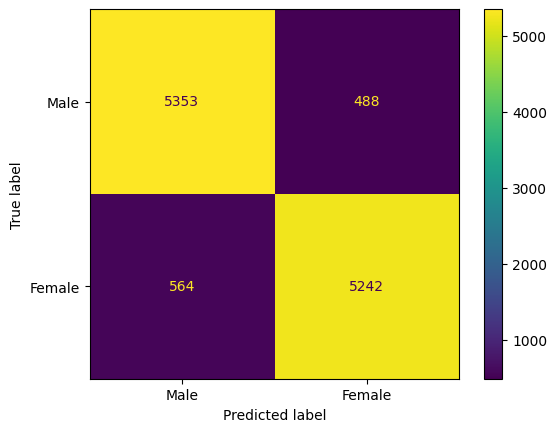

In [19]:
cm_display = ConfusionMatrixDisplay(confusion_matrix = conf_matrix, display_labels = ['Male', 'Female'])
cm_display.plot()
plt.show()

In [20]:
raise Exception("Eski Kod! Stop Here! Look at VGGTransferLearning.ipynb")

Exception: Eski Kod! Stop Here! Look at VGGTransferLearning.ipynb

In [ ]:
#torch.save(model.state_dict(), 'vgg_19_model.pth')

## Inference

In [ ]:
loaded_model = models.vgg16(pretrained=False)  # Load a new instance of VGG16
num_features = loaded_model.classifier[6].in_features
loaded_model.classifier[6] = nn.Sequential(
    nn.Linear(num_features, 256),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(256, 2)
)
loaded_model.load_state_dict(torch.load('vgg_model.pth'))
loaded_model = loaded_model.to(device)
loaded_model.eval()

In [ ]:
def preprocess_image(image_path):
    transform = transforms.Compose([
        transforms.Resize(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    image = Image.open(image_path)
    image = transform(image)
    image = image.unsqueeze(0)  # Add batch dimension
    return image.to(device)  # Move the image to GPU if available

image_paths = ['harun.jpg', 'arda.jpg', 'fatmanur.jpg']  # Provide paths to the images
for image_path in image_paths:
    input_image = preprocess_image(image_path)
    with torch.no_grad():
        output = loaded_model(input_image)
        probabilities = torch.softmax(output, dim=1)
        predicted_class = torch.argmax(probabilities, dim=1).item()
        predicted_label = class_names[predicted_class]
        print(f"Image: {image_path}, Predicted Gender: {predicted_label}")